In [4]:
import pandas as pd
import numpy as np
import bilby
import lal
import gwmemory
import gwpy
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import copy
import sys
sys.path.append("..")

from waveforms import osc_freq_XPHM, mem_freq_XPHM, mem_freq_XPHM_only
from create_post_dict import create_post_dict, extract_relevant_info

In [2]:
def call_data_GWOSC(logger, args, calibration, samples, detectors, start_time, end_time, psd_start_time, psd_end_time, duration, sampling_frequency, roll_off, minimum_frequency, maximum_frequency, psds_array=None, plot=False):
    
    ifo_list = bilby.gw.detector.InterferometerList([])
    
    # define interferometer objects
    for det in detectors:   
        logger.info("Downloading analysis data for ifo {}".format(det))
        ifo = bilby.gw.detector.get_empty_interferometer(det)
        
        channel_type = args['channel_dict'][det]
        channel = f"{det}:{channel_type}"
        
        kwargs = dict(
            start=start_time,
            end=end_time,
            verbose=False,
            allow_tape=True,
        )

        type_kwargs = dict(
            dtype="float64",
            subok=True,
            copy=False,
        )
        data = gwpy.timeseries.TimeSeries.get(channel, **kwargs).astype(
                **type_kwargs)
        
        # Resampling timeseries to sampling_frequency using lal.
        lal_timeseries = data.to_lal()
        lal.ResampleREAL8TimeSeries(
            lal_timeseries, float(1/sampling_frequency)
        )
        data = TimeSeries(
            lal_timeseries.data.data,
            epoch=lal_timeseries.epoch,
            dt=lal_timeseries.deltaT
        )
    
        # define some attributes in ifo
        ifo.strain_data.roll_off = roll_off
        ifo.maximum_frequency = maximum_frequency
        ifo.minimum_frequency = minimum_frequency
        
        # set data as the strain data
        ifo.strain_data.set_from_gwpy_timeseries(data)
        
        # compute the psd
        if det in psds_array.keys():
            print("Using pre-computed psd from results file")
            ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=psds_array[det][: ,0], psd_array=psds_array[det][:, 1]
            )
        else:
            print('Error: PSD is missing!')
            exit()

        ifo_list.append(ifo)

    return ifo_list

In [3]:
events = [('GW150914', '/home/shunyin.cheung/GWOSC_posteriors/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5', 1126259462.4, 4.0, "C01:IMRPhenomXPHM", None)]
event_name, file_path, trigger_time, duration, waveform, data_file = events[0]
amplitude = 100
print('amplitude = ',amplitude)

samples, meta_dict, config_dict, priors, psds, calibration = create_post_dict(file_path, waveform)
args = extract_relevant_info(meta_dict, config_dict)

priors2 = copy.copy(priors)

logger = bilby.core.utils.logger

sampling_frequency = args['sampling_frequency']
maximum_frequency = args['maximum_frequency']
minimum_frequency = args['minimum_frequency']
reference_frequency = args['reference_frequency']
roll_off = args['tukey_roll_off']
duration = args['duration']
post_trigger_duration = args['post_trigger_duration']
trigger_time = args['trigger_time']
detectors = args['detectors']
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

psd_duration = 32*duration # deprecated
psd_start_time = start_time - psd_duration # deprecated
psd_end_time = start_time # deprecated

ifo_list = call_data_GWOSC(logger, args, 
                            calibration, samples, detectors,
                            start_time, end_time, 
                            psd_start_time, psd_end_time, 
                            duration, sampling_frequency, 
                            roll_off, minimum_frequency, maximum_frequency,
                            psds_array=psds)

waveform_name = args['waveform_approximant']


# test if bilby oscillatory waveform = gwmemory oscillatory waveform.
waveform_generator_osc = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= bilby.gw.source.lal_binary_black_hole,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            waveform_approximant=waveform_name,
                            )

)

# define oscillatory + memory model using gwmemory.
waveform_generator_full = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

waveform_generator_mem = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM_only,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

target_likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifo_list,
    waveform_generator_full,
    time_marginalization = True,
    distance_marginalization = True,
    distance_marginalization_lookup_table = "'TD.npz'.npz",
    jitter_time=True,
    priors = priors,
    reference_frame = args['reference_frame'],
    time_reference = args['time_reference'],
)

amplitude =  100


18:18 bilby INFO    : Downloading analysis data for ifo H1


Jitter time setting cannot be found. Use default setting.
channel_dict {'H1': 'DCS-CALIB_STRAIN_C02', 'L1': 'DCS-CALIB_STRAIN_C02'}


18:18 bilby INFO    : Downloading analysis data for ifo L1


Using pre-computed psd from results file


18:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
18:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_v2
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
18:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_only
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
18:18 bilby INFO    : Loaded distance marginalisation lookup table from 'TD.npz'.npz.


Using pre-computed psd from results file


In [4]:
# posterior = samples.iloc[0].to_dict() # gives optimal snr of 0.057 for a=1.
# print(posterior)

# posterior = dict(   # gives optimal snr of 0.187 for a=1.
#     mass_1_source=35.3,
#     mass_2_source=29.6,
#     a_1=0.34,
#     a_2=0.32,
#     luminosity_distance=410,
#     theta_jn=np.pi/2,
#     psi=2.659,              
#     phase=5,                 
#     geocent_time=1126259642.413,
#     ra=3,                
#     dec=-1.2108,
#     tilt_1 = 0.79,
#     tilt_2 = 2.36,
#     time_jitter=0.0002,
# )

mean_parameters = dict()
for key in samples:
    value = np.mean(samples[key])
    mean_parameters[key] = value
    print(key, value)
posterior = mean_parameters
#posterior['iota'] = np.pi/2
#posterior['luminosity_distance'] = 410


chirp_mass 30.400821701255275
mass_ratio 0.8307741710658761
a_1 0.45229738201345254
a_2 0.4284578743290902
tilt_1 1.679481619472712
tilt_2 1.747634216227598
phi_12 3.0850520177515866
phi_jl 2.6790687139434253
theta_jn 2.6398080490059406
psi 1.501041951560141
phase 3.1468892385846883
azimuth 2.808103428359028
zenith 2.345699235929904
recalib_H1_amplitude_0 0.0013233822593898318
recalib_H1_amplitude_1 -0.007841268910774772
recalib_H1_amplitude_2 0.013302112706119452
recalib_H1_amplitude_3 0.008697336457196636
recalib_H1_amplitude_4 0.0003999388227566582
recalib_H1_amplitude_5 0.003075013225146587
recalib_H1_amplitude_6 -0.0019920909040871157
recalib_H1_amplitude_7 -0.004846690577873328
recalib_H1_amplitude_8 -0.00041702199479086134
recalib_H1_amplitude_9 -0.0016838429702933759
recalib_H1_phase_0 -0.011521868557628946
recalib_H1_phase_1 0.01787678931967589
recalib_H1_phase_2 -0.0026831465592351733
recalib_H1_phase_3 -0.004068726227358765
recalib_H1_phase_4 -0.0054775758112842
recalib_H1_p

In [5]:
# posterior = dict(   # gives optimal snr of 0.187 for a=1.
#     mass_1_source=35.3,
#     mass_2_source=29.6,
#     a_1=0.34,
#     a_2=0.32,
#     luminosity_distance=410,
#     theta_jn=np.pi/2,
#     psi=2.659,              
#     phase=5,                 
#     geocent_time=1126259642.413,
#     zenith = posterior2['zenith'],
#     azimuth = posterior2['azimuth'],  
#     ra = posterior2['ra'],
#     dec = posterior2['dec'],           
#     tilt_1 = 0.79,
#     tilt_2 = 2.36,
#     time_jitter=posterior2['time_jitter'],
# )
# print(posterior['theta_jn'])

384


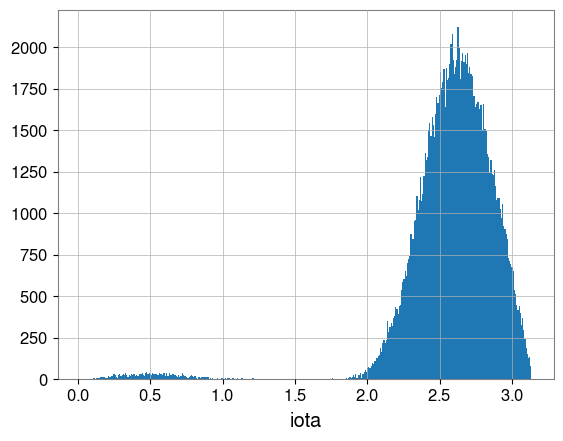

In [6]:
nbins = int(np.round(np.sqrt(len(samples['iota']))))
print(nbins)
plt.hist(samples['iota'], bins=nbins)
plt.xlabel('iota')
plt.show()

In [7]:
frequency_domain_strain = waveform_generator_full.frequency_domain_strain(posterior)
time_domain_strain_osc = waveform_generator_osc.time_domain_strain(posterior)
time_domain_strain_full = waveform_generator_full.time_domain_strain(posterior)
time_domain_strain_mem = waveform_generator_mem.time_domain_strain(posterior)
time_array = waveform_generator_full.time_array
target_likelihood.parameters.update(posterior)
snr_array_H1 = target_likelihood.calculate_snrs(frequency_domain_strain, ifo_list[0])
snr_array_L1 = target_likelihood.calculate_snrs(frequency_domain_strain, ifo_list[1])
opt_snr_H = snr_array_H1.optimal_snr_squared
opt_snr_L = snr_array_L1.optimal_snr_squared
cmf_snr_H = snr_array_H1.complex_matched_filter_snr
cmf_snr_L = snr_array_L1.complex_matched_filter_snr
print('full waveform')
print('network opt SNR: ', np.sqrt(opt_snr_H+opt_snr_L))
print('network complex matched_filter SNR', cmf_snr_H+cmf_snr_L)

full waveform
network opt SNR:  23.011078353833142
network complex matched_filter SNR (-33.00753264489853+9.985646831102624j)


In [8]:
frequency_domain_strain_mem = waveform_generator_mem.frequency_domain_strain(posterior)
snr_array_H1 = target_likelihood.calculate_snrs(frequency_domain_strain_mem, ifo_list[0])
snr_array_L1 = target_likelihood.calculate_snrs(frequency_domain_strain_mem, ifo_list[1])
opt_snr_H = snr_array_H1.optimal_snr_squared
opt_snr_L = snr_array_L1.optimal_snr_squared
cmf_snr_H = snr_array_H1.complex_matched_filter_snr
cmf_snr_L = snr_array_L1.complex_matched_filter_snr

print('memory-only waveform')
print('network opt SNR: ', np.sqrt(opt_snr_H+opt_snr_L))
print('network complex matched_filter SNR', cmf_snr_H+cmf_snr_L)

memory-only waveform
network opt SNR:  2.606440887359666
network complex matched_filter SNR (3.572901497759713+19.19174420048417j)


/home/shunyin.cheung/.conda/envs/altenv/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


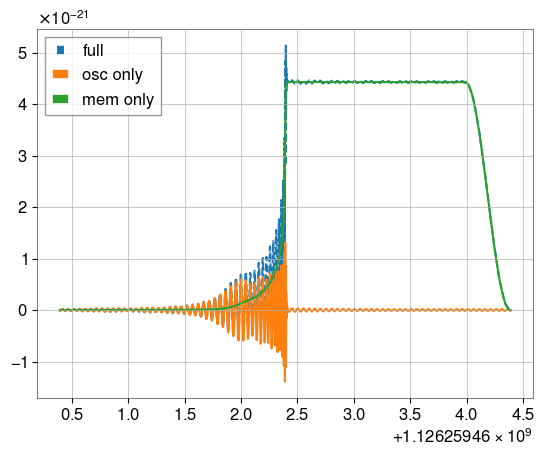

In [9]:
plt.figure()
plt.plot(time_array, np.roll(time_domain_strain_full['plus']-1j*time_domain_strain_full['cross'], -4096), linestyle='dashed', label='full')
plt.plot(time_array, np.roll(time_domain_strain_osc['plus']-1j*time_domain_strain_osc['cross'], -4096), label='osc only')
plt.plot(time_array, np.roll(time_domain_strain_mem['plus']-1j*time_domain_strain_mem['cross'], -4096), label='mem only')
plt.legend()
plt.savefig('tests/td_test.png')
plt.show()

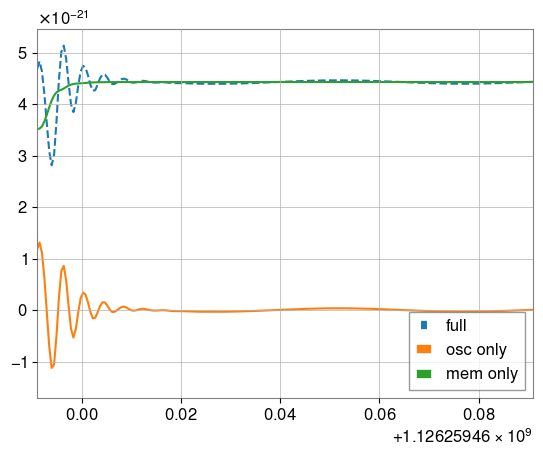

In [10]:
plt.figure()
plt.plot(time_array, time_domain_strain_full['plus']-1j*time_domain_strain_full['cross'], linestyle='dashed', label='full')
plt.plot(time_array, time_domain_strain_osc['plus']-1j*time_domain_strain_osc['cross'], label='osc only')
plt.plot(time_array, time_domain_strain_mem['plus']-1j*time_domain_strain_mem['cross'], label='mem only')
plt.xlim(start_time,start_time+0.1)
plt.legend()
plt.savefig('tests/td_test_zoomed.png')
plt.show()

# Normal Memory

In [18]:
amplitude=1

waveform_generator_mem = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM_only,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

frequency_domain_strain = waveform_generator_mem.frequency_domain_strain(posterior)
target_likelihood.parameters.update(posterior)
snr_array_H1 = target_likelihood.calculate_snrs(frequency_domain_strain, ifo_list[0])
snr_array_L1 = target_likelihood.calculate_snrs(frequency_domain_strain, ifo_list[1])
opt_snr_H = snr_array_H1.optimal_snr_squared
opt_snr_L = snr_array_L1.optimal_snr_squared
cmf_snr_H = snr_array_H1.complex_matched_filter_snr
cmf_snr_L = snr_array_L1.complex_matched_filter_snr
print('full waveform')
print('network opt SNR: ', np.sqrt(opt_snr_H+opt_snr_L))
print('network complex matched_filter SNR', cmf_snr_H+cmf_snr_L)

18:21 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_only
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


full waveform
network opt SNR:  0.026064408873596658
network complex matched_filter SNR (3.572901497759707+19.191744200484187j)


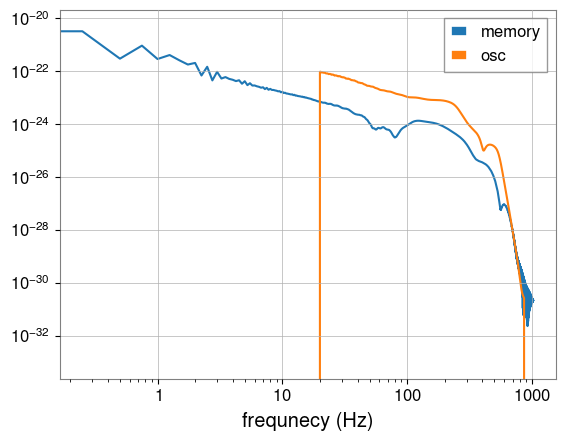

In [20]:
frequency_array = waveform_generator_mem.frequency_array
fd_strain_osc = waveform_generator_osc.frequency_domain_strain(posterior)


plt.figure()
plt.loglog(frequency_array, 100*np.abs(frequency_domain_strain['plus']+frequency_domain_strain['cross']), label='memory')
plt.loglog(frequency_array, np.abs(fd_strain_osc['plus']+fd_strain_osc['cross']), label='osc')
plt.xlabel('frequnecy (Hz)')
plt.legend()
plt.show()

# Zero Memory

In [13]:
amplitude = 0

waveform_generator_osc = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= bilby.gw.source.lal_binary_black_hole,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            waveform_approximant=waveform_name,
                            )

)

# define oscillatory + memory model using gwmemory.
waveform_generator_full = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

waveform_generator_mem = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= mem_freq_XPHM_only,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,
                            amplitude=amplitude)

)

frequency_domain_strain = waveform_generator_full.frequency_domain_strain(posterior)
time_domain_strain_osc = waveform_generator_osc.time_domain_strain(posterior)
time_domain_strain_full = waveform_generator_full.time_domain_strain(posterior)
time_domain_strain_mem = waveform_generator_mem.time_domain_strain(posterior)
time_array = waveform_generator_full.time_array
target_likelihood.parameters.update(posterior)
snr_array_H1 = target_likelihood.calculate_snrs(frequency_domain_strain, ifo_list[0])
snr_array_L1 = target_likelihood.calculate_snrs(frequency_domain_strain, ifo_list[1])
opt_snr_H = snr_array_H1.optimal_snr_squared
opt_snr_L = snr_array_L1.optimal_snr_squared
cmf_snr_H = snr_array_H1.complex_matched_filter_snr
cmf_snr_L = snr_array_L1.complex_matched_filter_snr
print('full waveform')
print('network opt SNR: ', np.sqrt(opt_snr_H+opt_snr_L))
print('network complex matched_filter SNR', cmf_snr_H+cmf_snr_L)

18:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
18:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_v2
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
18:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.mem_freq_XPHM_only
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


full waveform
network opt SNR:  22.17194495135922
network complex matched_filter SNR (-33.718460857767866+8.003409882129638j)


# Check Aligment

18:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveforms.osc_freq_XPHM
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


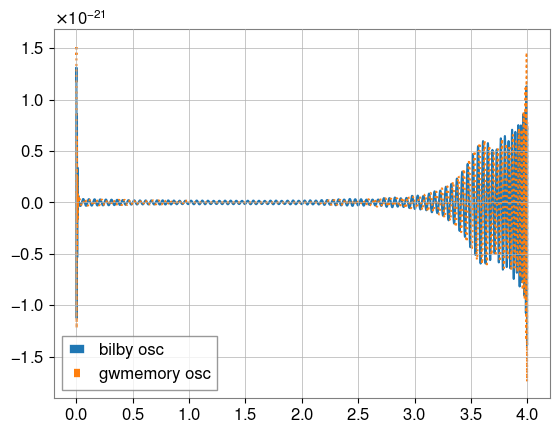

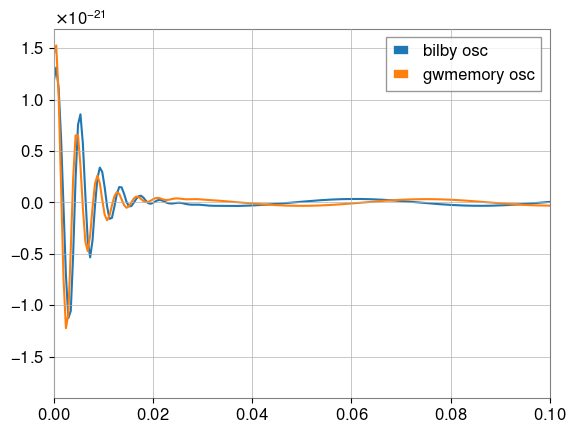

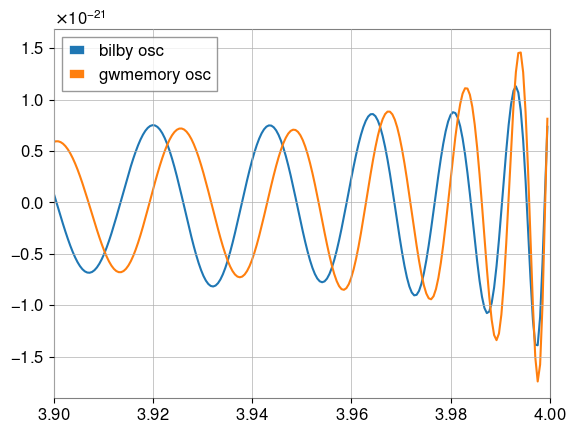

In [14]:
# define oscillatory + memory model using gwmemory.
waveform_generator_gwmemory_osc = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model= osc_freq_XPHM,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(duration=duration,
                            roll_off=roll_off,
                            minimum_frequency=minimum_frequency,
                            maximum_frequency=maximum_frequency,
                            sampling_frequency=sampling_frequency,
                            reference_frequency=reference_frequency,
                            bilby_generator = waveform_generator_osc,)

)

time_domain_strain_mem = waveform_generator_gwmemory_osc.time_domain_strain(posterior)
time_array = waveform_generator_gwmemory_osc.time_array

plt.figure()
plt.plot(time_array, time_domain_strain_osc['plus']-1j*time_domain_strain_osc['cross'], label='bilby osc')
plt.plot(time_array, time_domain_strain_mem['plus']-1j*time_domain_strain_mem['cross'], label='gwmemory osc', linestyle='dotted')
plt.legend()
plt.show()

plt.figure()
plt.plot(time_array, time_domain_strain_osc['plus']-1j*time_domain_strain_osc['cross'], label='bilby osc')
plt.plot(time_array, time_domain_strain_mem['plus']-1j*time_domain_strain_mem['cross'], label='gwmemory osc')
plt.xlim(0,0.1)
plt.legend()
plt.show()

plt.figure()
plt.plot(time_array, time_domain_strain_osc['plus']-1j*time_domain_strain_osc['cross'], label='bilby osc')
plt.plot(time_array, time_domain_strain_mem['plus']-1j*time_domain_strain_mem['cross'], label='gwmemory osc')
plt.xlim(3.9,4)
plt.legend()
plt.show()